# Draft `pyGIMLi(emg3d)`

**NEEDS**
- `pyGIMLi`
- `emg3d`
- `discretize`
- `xarray`
- `h5py`

**Current Limitations**
- Only isotropic models supported, without el. perm. and magn. perm.

An attempt at using `pyGIMLi` as an inversion framework for `emg3d` computations.

For developping purposes, we take a very simple grid/model/survey:
- Coarse mesh, no stretching (potentially too small).
- Simple double-halfspace model water-subsurface with a resistive block.
- Survey: A single 2D line, 6 sources, 1 frequency.

=> For this dev-implementation we also do inversion crime, using the same grid for forward modelling and inversion.

In [1]:
import emg3d
import numpy as np
import pygimli as pg
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

In [2]:
%matplotlib notebook

In [3]:
pg.Report('emg3d')

--------------------------------------------------------------------------------
  Date: Tue Dec 13 19:51:58 2022 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 15:55:03)
  [GCC 10.4.0]

             emg3d : 1.8.0
           pygimli : 1.3.1+12.g01b7fae7 (dev)
            pgcore : Version unknown
             numpy : 1.20.3
        matplotlib : 3.5.1
             scipy : 1.9.1
              tqdm : 4.64.1
           IPython : 8.5.0
           pyvista : 0.34.2
--------------------------------------------------------------------------------

## Load survey (incl. data) and initial model

In [4]:
# obsdata = emg3d.load('pginv.h5')
obsdata = emg3d.load('pginv-coarse.h5')  # VERY COARSE (to develop)
survey = obsdata['survey']
model = obsdata['model']
grid = model.grid

Data loaded from «/home/dtr/Codes/dev-pygimli-emg3d/pginv-coarse.h5»
[emg3d v1.8.1 (format 1.0) on 2022-12-13T18:44:55.814751].


## Jacobian Wrapper

In [5]:
class EMG3DJacobian(pg.Matrix):
    
    def __init__(self, sim):
        super().__init__()
        self.sim = sim

    def cols(self):
        # sim.model.size corresponds to the number of cells
        return self.sim.model.size

    def rows(self):
        # sim.survey.count corresponds to the number of non-NaN data points.
        return self.sim.survey.count * 2

    def mult(self, x):
        """J * x """
        # reshape or ravel
        jvec = self.sim.jvec(np.reshape(x, self.sim.model.shape, order='F'))
        data = jvec[self.sim._finite_data]
        return np.hstack((data.real, data.imag))

    def transMult(self, x):
        """J.T * x = (x * J.T)^T """
        data = np.ones(survey.data.observed.shape, dtype=self.sim.data.observed.dtype)*np.nan
        x = np.asarray(x)
        data[self.sim._finite_data] = x[:x.size//2] + 1j*x[x.size//2:]
        misfit = self.sim.misfit
        return self.sim.jtvec(data).ravel('F')
    
    def save(self, *args):
        pass

## Forward Wrapper

In [6]:
class MyFWD(pg.Modelling):
    
    def __init__(self, sim):
        
        # Should it be here or at the end of the __init__?
        super().__init__()
        
        # Not sure if this is the best way, but for now it works
        sim._finite_data = np.isfinite(sim.data.observed.data)
        
        # Store the simulation
        # (I replaced «fop» by «sim».)
        self.sim = sim
        
        # Translate discretize TensorMesh to pg-Grid
        self.mesh_ = pg.createGrid(
            x=sim.model.grid.nodes_x,
            y=sim.model.grid.nodes_y,
            z=sim.model.grid.nodes_z,
        )
        
        # It should work here, as pg.Modelling was initiated above
        self.setMesh(self.mesh_)
        
        self.J = EMG3DJacobian(sim)
        self.setJacobian(self.J)

    def response(self, model):
        # do a lot of checks and cleanups
        
        # Clean emg3d-simulation, so things are recomputed
        self.sim.clean('computed')
        
        # Replace model
        self.sim.model = emg3d.Model(self.sim.model.grid, property_x=model)
        
        # Compute responses for new model
        self.sim.compute()
        
        # Return the responses
        data = self.sim.data.synthetic.data[self.sim._finite_data]
        return np.hstack((data.real, data.imag))
    
    def createStartModel(self, dataVals):   # WHY «dataVals» ??????
        # Use the model in the simulation as starting model
        # => make this more flexibel!
        return self.sim.model.property_x.ravel('F')
    
    def createJacobian(self, model):
        pass  # do nothing

## Run an inversion

In [7]:
# Create an emg3d Simulation instance
sim = emg3d.simulations.Simulation(
    survey=survey,
    model=model,
    gridding='same',  # I will like to make that more flexible in the future
    max_workers=4,    # Adjust as needed
    receiver_interpolation='linear',  # Currently necessary for the gradient
    # solver_opts,
    tqdm_opts=False,  # Switch off verbose progress bars
    #solver_opts={'plain': True, 'maxit': 1},  # Just for dev-purpose
    #solver_opts={'tol': 1e-4},  # Just for dev-purpose
)

In [8]:
from pygimli.frameworks.lsqrinversion import LSQRInversion
fop = MyFWD(sim)
# INV = pg.Inversion(fop=fop, verbose=True, debug=True)
INV = LSQRInversion(fop=fop, verbose=True)  #, debug=True)
INV.LSQRiter = 20  # just solve lowest wavelengths
INV.transData = pg.trans.TransSymLog(survey.noise_floor/100)
INV.transModel = pg.trans.TransLogLU(1, 1000)

# Regularization: Setting active/passive cells would be great,
# e.g., de-activating air and water for the inversion.
# And of course other regularizations (smoothness etc).
# INV.setRegularization(limits=[], correlationLengths=[...])
# INV.setRegularization(2, fix=1e-14) # air
# INV.setRegularization(3, fix=10.0) # water

dataC = sim.data.observed.data[fop.sim._finite_data].copy()
data = np.hstack([dataC.real, dataC.imag])

errorsC = sim.survey.standard_deviation.data[fop.sim._finite_data]
errors = np.hstack([errorsC, errorsC])
#errors = np.ones(data.size)*sim.survey.relative_error
# emg3d would have the standard deviation, existing of
# relative and absolute error. Could that be provided?

13/12/22 - 19:52:02 - pyGIMLi - WARNING - Found zero error values. Setting them to fallback value of 1
/home/carsten/miniconda3/envs/build/conda-bld/pgcore_1661190390662/work/gimli/core/src/inversion.h:247		void GIMLI::RInversion::checkError()  Warning error contains zero values, reset to default. 
13/12/22 - 19:52:02 - pyGIMLi - INFO - Created startmodel from forward operator: [1.  1.  1.  ... 0.3 0.3 0.3]
13/12/22 - 19:52:02 - pyGIMLi - INFO - Starting inversion.


[2.45038350e-11 5.53627495e-11 1.12055004e-10 2.57113227e-10
 5.84240954e-10 1.65442726e-09 5.75621782e-10 2.63406338e-10
 1.02573805e-10 5.58080687e-11 2.24670807e-11 1.14057727e-11
 5.99750948e-12 3.08341914e-12 1.51978428e-12 7.70464673e-13
 4.27644281e-13 2.38363027e-13 1.50747570e-13 8.83251873e-14
 6.40348995e-14 4.66902928e-14 3.57684509e-14 2.77607219e-14
 2.24211296e-14 1.84638305e-14 1.55442824e-14 1.39717936e-14
 1.15242181e-14 1.01062676e-14 8.83245461e-15 7.59124703e-15
 6.68820423e-15 5.41722636e-15 3.85713022e-15 2.89254812e-15
 2.29304299e-15 1.72980840e-15 1.33386384e-15 1.18816698e-15
 1.07917022e-15 1.03337168e-15 1.00908165e-15 1.00167153e-15
 1.00043275e-15 1.00015798e-15 1.11597187e-15 1.28631536e-15
 1.83284056e-15 2.75228935e-15 4.47292211e-15 6.81525605e-15
 1.21500899e-14 2.07683676e-14 3.49649599e-14 5.69910732e-14
 8.75213332e-14 1.40441451e-13 2.53063135e-13 3.74835897e-13
 6.74392059e-13 1.10182974e-12 1.75297742e-12 3.13715958e-12
 6.25246579e-12 1.237283

13/12/22 - 19:52:09 - pyGIMLi - INFO - 0 9.803132947239526 1.0
13/12/22 - 19:52:49 - pyGIMLi - INFO - 10 378.791947511279 38.63988681474971
13/12/22 - 19:53:27 - pyGIMLi - INFO - Maximum iteration reached
13/12/22 - 19:53:27 - pyGIMLi - INFO - 19 129.34496305753197 13.19424756898297


<IPython.core.display.Javascript object>


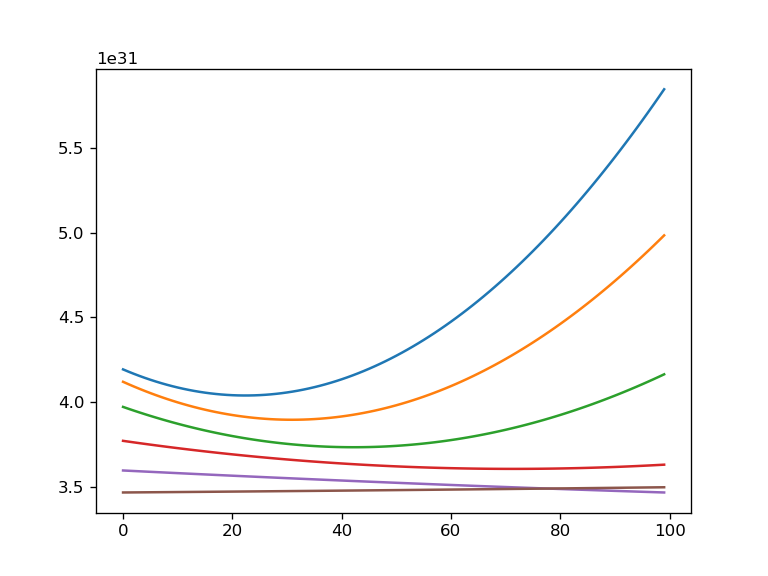

chi² = 427.14 (dPhi = 1.74%) lam: 20
--------------------------------------------------------------------------------
inv.iter 3 ... Running one inversion step!


13/12/22 - 19:53:33 - pyGIMLi - INFO - 0 9.755667457000941 1.0
13/12/22 - 19:54:14 - pyGIMLi - INFO - 10 433.6287868970651 44.44891021637693
13/12/22 - 19:54:59 - pyGIMLi - INFO - Maximum iteration reached
13/12/22 - 19:54:59 - pyGIMLi - INFO - 19 111.35119738123777 11.414000925311269


chi² = 751.78 (dPhi = 3.59%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... Running one inversion step!


13/12/22 - 19:55:05 - pyGIMLi - INFO - 0 8.452930757927453 1.0
13/12/22 - 19:55:48 - pyGIMLi - INFO - 10 340.74562733799496 40.31094505517295
13/12/22 - 19:56:28 - pyGIMLi - INFO - Maximum iteration reached
13/12/22 - 19:56:28 - pyGIMLi - INFO - 19 99.01645912083056 11.713861376182395


chi² = 1387.95 (dPhi = 5.03%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 5 ... Running one inversion step!


13/12/22 - 19:56:33 - pyGIMLi - INFO - 0 5.717421508436545 1.0
13/12/22 - 19:57:09 - pyGIMLi - INFO - 10 229.26580828915314 40.099511283338444
13/12/22 - 19:57:47 - pyGIMLi - INFO - Maximum iteration reached
13/12/22 - 19:57:47 - pyGIMLi - INFO - 19 93.67777922422718 16.384620074975686


chi² = 2030.67 (dPhi = 4.63%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 6 ... Running one inversion step!


13/12/22 - 19:57:52 - pyGIMLi - INFO - 0 1.9985358608768822 1.0
13/12/22 - 19:58:29 - pyGIMLi - INFO - 10 57.86029906370718 28.95134392951061
13/12/22 - 19:59:06 - pyGIMLi - INFO - Maximum iteration reached
13/12/22 - 19:59:06 - pyGIMLi - INFO - 19 147.74616195191282 73.9272008294549


chi² = 904.3 (dPhi = 3.6%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 7 ... Running one inversion step!


13/12/22 - 19:59:10 - pyGIMLi - INFO - 0 2.3238601848929914 1.0
13/12/22 - 19:59:47 - pyGIMLi - INFO - 10 49.902694898935664 21.474052192702622
13/12/22 - 20:00:23 - pyGIMLi - INFO - Maximum iteration reached
13/12/22 - 20:00:23 - pyGIMLi - INFO - 19 115.66854759391711 49.77431445568804


chi² = 805.16 (dPhi = -0.06%) lam: 20.0
################################################################################
#                Abort criteria reached: dPhi = -0.06 (< 2.0%)                 #
################################################################################


In [9]:
# For a reference model
#INV.run(..., startModel=mymodel, isReference=True)

errmodel = INV.run(
    dataVals=data,
    errorVals=errors,
    #maxIter=2, # just to test
    verbose=True,
    #isReference=True,
)

In [10]:
# Compute the response of the starting model for QC
sim2 = sim.copy()
sim2.clean('computed')
sim2.model = obsdata['model']
sim2.compute()

<IPython.core.display.Javascript object>


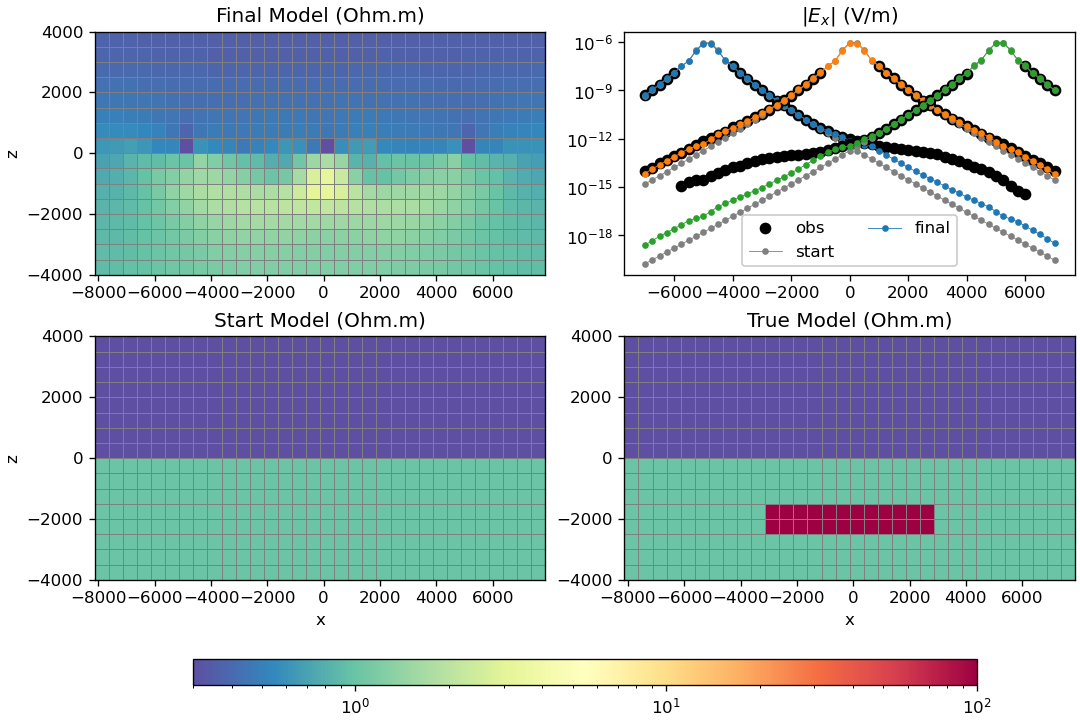

In [11]:
popts = {'edgecolors': 'grey', 'linewidth': 0.5, 'cmap':'Spectral_r','norm':LogNorm(vmin=0.3, vmax=100)}
opts = {'v_type': 'CC', 'normal': 'Y', 'pcolor_opts': popts}

fig, axs = plt.subplots(2, 2, figsize=(9, 6), constrained_layout=True)
(ax1, ax2), (ax3, ax4) = axs

out1, = grid.plot_slice(np.array(INV.model), ax=ax1, **opts)
ax1.set_title(f"Final Model (Ohm.m)")
ax1.set_xlabel('')

out3, = grid.plot_slice(obsdata['model'].property_x.ravel('F'), ax=ax3, **opts)
ax3.set_title(f"Start Model (Ohm.m)")

out4, = grid.plot_slice(obsdata['true_model'].property_x.ravel('F'), ax=ax4, **opts)
ax4.set_title(f"True Model (Ohm.m)")
ax4.set_ylabel('')

####
obs = sim.data.observed
syn = sim.data.synthetic
ini = sim2.data.synthetic
rec_coords = survey.receiver_coordinates()

for i, src in enumerate(survey.sources.keys()):
    ax2.plot(rec_coords[0], abs(obs.loc[src, :, :].data), "ko", label='obs' if i == 0 else '')
    ax2.plot(rec_coords[0], abs(ini.loc[src, :, :].data), ".-", c='.5', lw=0.5, label='start' if i == 0 else '')
    ax2.plot(rec_coords[0], abs(syn.loc[src, :, :].data), f"C{i}.-", lw=0.5, label='final' if i == 0 else '')

ax2.set_yscale('log')
ax2.legend(ncol=2, framealpha=1)
ax2.set_title('$|E_x|$ (V/m)')

####

plt.colorbar(out1, ax=axs, orientation='horizontal', fraction=.1, shrink=.8, aspect=30);